In [22]:
import numpy as np
import seaborn as sns
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import os
import cv2

In [23]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [24]:
# !unzip gdrive/My\ Drive/ColabNotebooks/FacialExpressionsDetection/FED_from_scratch/fed_dataset.zip

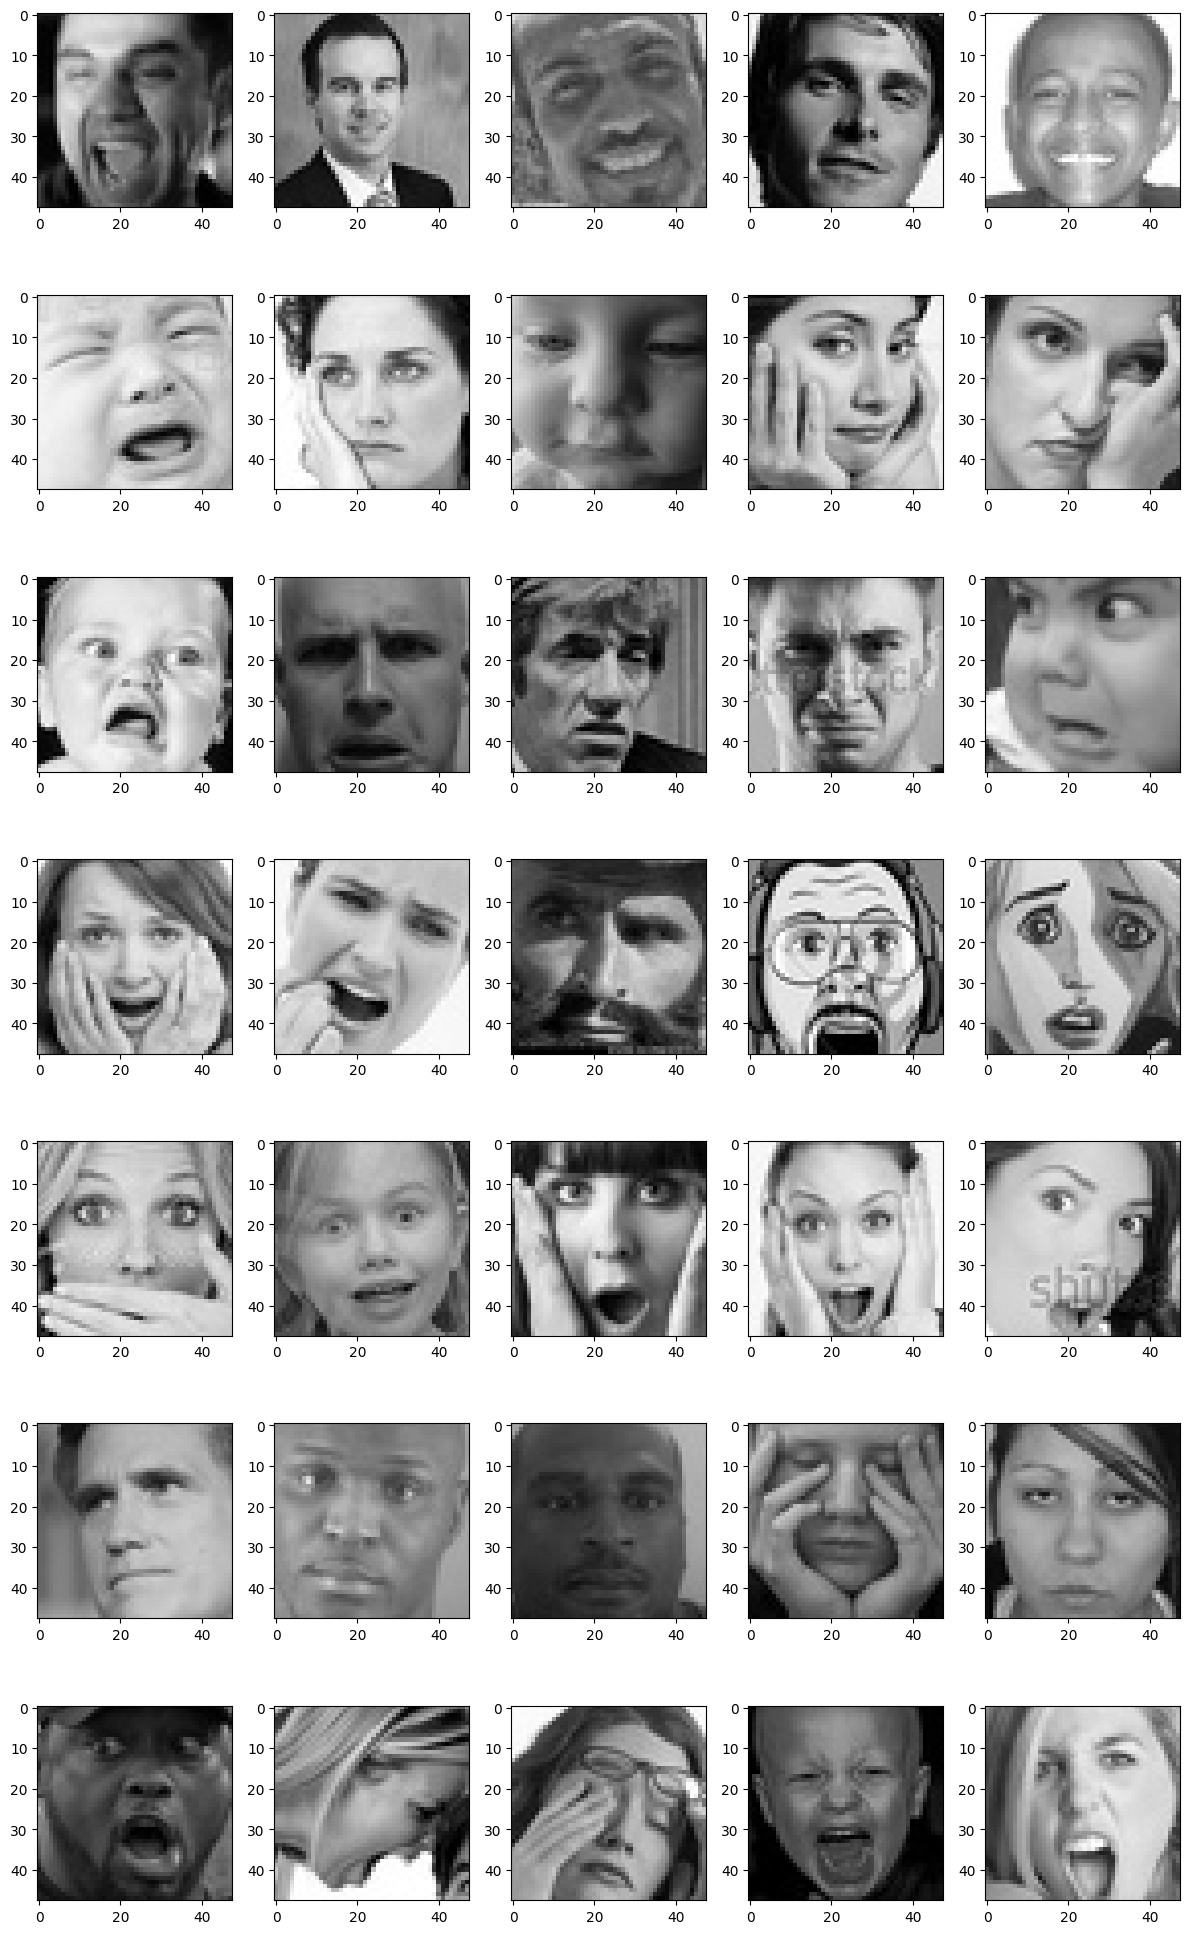

In [25]:
base_path = "images/images/"
pic_size = 48

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [26]:
for expression in os.listdir(base_path + "train"):
  print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images.")

7164 happy images.
4938 sad images.
436 disgust images.
4103 fear images.
3205 surprise images.
4982 neutral images.
3993 angry images.


In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
batch_size = 128
datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

In [29]:
train_generator = datagen_train.flow_from_directory(
    base_path + "train",
    target_size = (pic_size, pic_size),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 28821 images belonging to 7 classes.


In [30]:
validation_generator = datagen_validation.flow_from_directory(
    base_path + "validation",
    target_size = (pic_size, pic_size),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 7066 images belonging to 7 classes.


In [31]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization,Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [32]:
number_of_classes = 7
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 2nd Convolution
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 3rd Convolution
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 4th Convolution Layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# 1st Fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(number_of_classes, activation = 'softmax'))

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [34]:
epochs = 20
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model_weights2.h5", monitor = "val_accuracy",
                             verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                        factor = 0.2,
                                        patience = 3,
                                        verboe = 1,
                                        min_delta = 0.0001)

checkbacks_list = [early_stopping, checkpoint, reduce_learningrate]

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [35]:
history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch= train_generator.n// train_generator.batch_size,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n // validation_generator.batch_size,
                              callbacks = checkbacks_list)

Epoch 1/20


<ipython-input-35-1f7e5b2fb4f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


225/225 [==============================] - ETA: 0s - loss: 1.8003 - accuracy: 0.3090
Epoch 1: val_accuracy improved from -inf to 0.31733, saving model to ./model_weights2.h5
225/225 [==============================] - 19s 77ms/step - loss: 1.8003 - accuracy: 0.3090 - val_loss: 1.6806 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.4569 - accuracy: 0.4378
Epoch 2: val_accuracy improved from 0.31733 to 0.41392, saving model to ./model_weights2.h5
225/225 [==============================] - 17s 77ms/step - loss: 1.4569 - accuracy: 0.4378 - val_loss: 1.5369 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.2808 - accuracy: 0.5123
Epoch 3: val_accuracy improved from 0.41392 to 0.47472, saving model to ./model_weights2.h5
225/225 [==============================] - 17s 76ms/step - loss: 1.2808 - accuracy: 0.5123 - val_loss: 1.3339 - val_accuracy: 0.4747 - lr: 0.0010
Epoch 4/20
2

In [36]:
# model.save('gdrive/MyDrive/ColabNotebooks/FacialExpressionsDetection/FED_from_scratch/ready_model.h5')

In [37]:
# import pickle
# filename = 'pickle_model'
# pickle.dump(model, open(filename, 'wb'))

In [40]:
# model.save('gdrive/MyDrive/ColabNotebooks/FacialExpressionsDetection/FED_from_scratch/model_trained')

In [39]:
# import tensorflow as tf
# tf.saved_model.save(model, export_dir='Trained_transformer')